# Creating an RL Based ABR Streaming Algorithm 

In [1]:
# Default python packages
import os
import argparse
import random
import math
import io
import contextlib

# installed packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# packages in this repo
import sabre
from environment import ABR_Env

## Load the Dataset

In [8]:
def get_files(d): 
    return [os.path.join(d, f) for f in os.listdir(d)]
    
def get_movie_manifest(movie_filename):
    manifest = sabre.load_json(movie_filename)                                                                                                                                                        
    manifest = sabre.ManifestInfo(segment_time = manifest['segment_duration_ms'], 
                    bitrates    = manifest['bitrates_kbps'],                                         
                    utilities    = [math.log(b) - math.log(manifest['bitrates_kbps'][0]) for b in manifest['bitrates_kbps']], 
                    segments     = manifest['segment_sizes_bits'])
    return manifest
    
network_hd_dir = '../data/hd_fs'
network_sd_dir = '../data/sd_fs'
network_3G_dir = '../data/3Glogs'
network_4G_dir = '../data/4Glogs'

network_traces = {
    'hd_traces':get_files(network_hd_dir),
    'sd_traces':get_files(network_sd_dir),
    '3G_traces':get_files(network_3G_dir),
    '4G_traces':get_files(network_4G_dir),
}

movies = ['../data/bbb.json',] #  '../data/bbb4k.json']
manifests = [get_movie_manifest(m) for m in movies]

# for now seed the random in order to save the trained model one day
# and then re-run the code to test another day
random.seed(69420) 

n_views_per_trace = 1
n_chunks = sum(len(m.segments) for m in manifests)
print('Summary of Network Data:')
test_train_split = 0.75
for k, v in network_traces.items():
    np.random.shuffle(v)
    idx = int(np.floor(test_train_split * len(v)))
    n_train = n_views_per_trace * n_chunks * idx
    n_test  = n_chunks * (len(v) - idx)
    network_traces[k] = {
        'train': v[:idx],
        'train_steps': n_train,
        'test':  v[idx:],
        'test_steps': n_test
    }
    print(f'  {k}: ')
    print(f'    Training {idx} samples, {n_train} steps to train')
    print(f'    Testing  {len(v) - idx} samples, {n_test}  steps to test')
    print('')

DATA = network_traces['hd_traces']
manifest = manifests[0]
qoe_alpha, qoe_beta, qoe_delta = (1/len(manifest.bitrates), 1/(4*len(manifest.bitrates)), len(manifest.segments)/(7*manifest.segment_time))
print(qoe_alpha, qoe_beta, qoe_delta)

Summary of Network Data:
  hd_traces: 
    Training 750 samples, 149250 steps to train
    Testing  250 samples, 49750  steps to test

  sd_traces: 
    Training 750 samples, 149250 steps to train
    Testing  250 samples, 49750  steps to test

  3G_traces: 
    Training 64 samples, 12736 steps to train
    Testing  22 samples, 4378  steps to test

  4G_traces: 
    Training 30 samples, 5970 steps to train
    Testing  10 samples, 1990  steps to test

0.1 0.025 0.009476190476190477


## Train and save several models

### A2C

In [9]:
from stable_baselines3 import A2C

TRAIN_NEW_A2C  = True
MODEL_PATH_A2C = '../models/a2c.model'

env = ABR_Env(
    DATA['train'],
    movies,
    r_multipliers=[qoe_alpha, qoe_beta, qoe_delta],
)
env_train = env.get_sb_env()
if TRAIN_NEW_A2C:
    model_a2c = A2C('MultiInputPolicy', env_train, verbose=0, device='cpu')
    model_a2c.learn(total_timesteps=DATA['train_steps'])
    model_a2c.save(MODEL_PATH_A2C)
elif os.path.exists(MODEL_PATH_A2C):
    print(f'Loading A2C model from "{MODEL_PATH_A2C}"')
    model_a2c = A2C.load(MODEL_PATH_A2C, env)
else:
    raise Exception('No A2C model to load')

### DDPG

In [10]:
from stable_baselines3 import DDPG
TRAIN_NEW_DDPG  = True
MODEL_PATH_DDPG = '../models/ddpg.model'

env = ABR_Env(
    DATA['train'],
    movies,
    r_multipliers=[qoe_alpha, qoe_beta, qoe_delta],
)
env_train = env.get_sb_env()
if TRAIN_NEW_DDPG:
    model_ddpg = DDPG('MultiInputPolicy', env_train, verbose=1, device='cuda')
    model_ddpg.learn(total_timesteps=DATA['train_steps'])
    model_ddpg.save(MODEL_PATH_DDPG)
elif os.path.exists(MODEL_PATH_DDPG):
    print(f'Loading DDPG model from "{MODEL_PATH_DDPG}"')
    model_ddpg = DDPG.load(MODEL_PATH_DDPG)
else:
    raise Exception('No DDPG model to load')

Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 81        |
|    time_elapsed    | 9         |
|    total_timesteps | 796       |
| train/             |           |
|    actor_loss      | -3.11e+03 |
|    critic_loss     | 1.87e+08  |
|    learning_rate   | 0.001     |
|    n_updates       | 695       |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 83       |
|    time_elapsed    | 19       |
|    total_timesteps | 1592     |
| train/             |          |
|    actor_loss      | -23.5    |
|    critic_loss     | 2.63e+07 |
|    learning_rate   | 0.001    |
|    n_updates       | 1491     |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 12        |
|    fps             | 83        |
|    time_elap

## Test the ABR Algorithms and Gather Results

The argparse arguments were copied and pased from the modified `sabre.py` file. Note, minor changes were made where any variable that was used had to be changed to sabre.var_name. 

In [11]:
parser = argparse.ArgumentParser(description = 'Simulate an ABR session.',
                                 formatter_class = argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('-n', '--network', metavar = 'NETWORK', default = 'network.json',
                    help = 'Specify the .json file describing the network trace.')
parser.add_argument('-nm', '--network-multiplier', metavar = 'MULTIPLIER',
                    type = float, default = 1,
                    help = 'Multiply throughput by MULTIPLIER.')
parser.add_argument('-m', '--movie', metavar = 'MOVIE', default = 'movie.json',
                    help = 'Specify the .json file describing the movie chunks.')
parser.add_argument('-ml', '--movie-length', metavar = 'LEN', type = float, default = None,
                    help = 'Specify the movie length in seconds (use MOVIE length if None).')
parser.add_argument('-a', '--abr', metavar = 'ABR',
                    default = sabre.abr_default,
                    help = 'Choose ABR algorithm from predefined list (%s), or specify .py module to import.' % ', '.join(sabre.abr_list.keys()))
parser.add_argument('-ab', '--abr-basic', action = 'store_true',
                    help = 'Set ABR to BASIC (ABR strategy dependant).')
parser.add_argument('-ao', '--abr-osc', action = 'store_true',
                    help = 'Set ABR to minimize oscillations.')
parser.add_argument('-gp', '--gamma-p', metavar = 'GAMMAP', type = float, default = 5,
                    help = 'Specify the (gamma p) product in seconds.')
parser.add_argument('-noibr', '--no-insufficient-buffer-rule', action = 'store_true',
                    help = 'Disable Insufficient Buffer Rule.')
parser.add_argument('-ma', '--moving-average', metavar = 'AVERAGE',
                    choices = sabre.average_list.keys(), default = sabre.average_default,
                    help = 'Specify the moving average strategy (%s).' %
                    ', '.join(sabre.average_list.keys()))
parser.add_argument('-ws', '--window-size', metavar = 'WINDOW_SIZE',
                    nargs = '+', type = int, default = [3],
                    help = 'Specify sliding window size.')
parser.add_argument('-hl', '--half-life', metavar = 'HALF_LIFE',
                    nargs = '+', type = float, default = [3, 8],
                    help = 'Specify EWMA half life.')
parser.add_argument('-s', '--seek', nargs = 2, metavar = ('WHEN', 'SEEK'),
                    type = float, default = None,
                    help = 'Specify when to seek in seconds and where to seek in seconds.')
choices = ['none', 'left', 'right']
parser.add_argument('-r', '--replace', metavar = 'REPLACEMENT',
                    #choices = choices,
                    default  =  'none',
                    help = 'Set replacement strategy from predefined list (%s), or specify .py module to import.' % ', '.join(choices))
parser.add_argument('-b', '--max-buffer', metavar = 'MAXBUFFER', type = float, default = 25,
                    help = 'Specify the maximum buffer size in seconds.')
parser.add_argument('-noa', '--no-abandon', action = 'store_true',
                    help = 'Disable abandonment.')
parser.add_argument('-rmp', '--rampup-threshold', metavar = 'THRESHOLD',
                    type = int, default = None,
                    help = 'Specify at what quality index we are ramped up (None matches network).')
parser.add_argument('-v', '--verbose', action = 'store_true',
                    help = 'Run in verbose mode.')

_StoreTrueAction(option_strings=['-v', '--verbose'], dest='verbose', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='Run in verbose mode.', metavar=None)

### Gathering the Data
Now that the args have been defined to run sabre, the `test_algorithm` function was written to wrap the call. The results are then saved in a data frame for the given traces and movies to test. 

In [ ]:
def parse_sabre(text):
    data = {}
    for line in text.splitlines():
        line = line.split(':')
        assert len(line) == 2
        metric, value = line[0], float(line[1].strip())
        data[metric] = value
    return data

def test_algorithm(movies, traces, abr_algo, print_progress=True) -> pd.DataFrame:
    if print_progress:
        print(f'getting results for: {abr_algo}')

    data = []
    for m in movies:
        for t in traces:
            data_row = {'movie':m, 'network_trace':t, 'algorithm':abr_algo}
            # parse the args for sabre to run. 
            # This would normally be done via cli, 
            # but it is convienient here to do in the notebook
            args = parser.parse_args([
                '--abr', abr_algo,
                '--movie', m,
                '--network', t,
                '--no-abandon',
            ])
            # capture the results that sabre prints to stdout
            with io.StringIO() as buf, contextlib.redirect_stdout(buf):
                sabre.args = args
                sabre.main(args)
                stdout = buf.getvalue() 
            # parse the stdout text to a more consumable dict format
            results   = parse_sabre(stdout)
            data_row.update(results)
            data.append(data_row)
    return pd.DataFrame(data)

a2C_results  = test_algorithm(movies, DATA['test'], 'ABR_A2C.py')
ddpg_results = test_algorithm(movies, DATA['test'], 'ABR_DDPG.py')
# a2C_111_results  = test_algorithm(movies, DATA['test'], 'ABR_A2C_111.py')
# ddpg_111_results = test_algorithm(movies, DATA['test'], 'ABR_DDPG_111.py')
bola_results    = test_algorithm(movies, DATA['test'], 'bola')
dynamic_results = test_algorithm(movies, DATA['test'], 'dynamic')

results_df = pd.concat([a2C_results, ddpg_results, bola_results, dynamic_results])
results_df['qoe']  = qoe_alpha * results_df['time average played bitrate']
results_df['qoe'] -= qoe_beta  * results_df['time average bitrate change']
results_df['qoe'] -= qoe_delta * results_df['time average rebuffer']


print('data frame shape: ', results_df.shape)
print('columns: ', results_df.columns)

results_df.to_csv('../results/results_df.csv', index=False)

getting results for: ABR_A2C.py


## Analyze the results

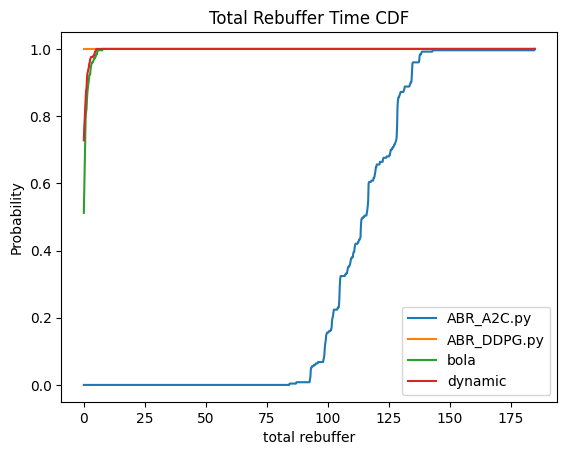

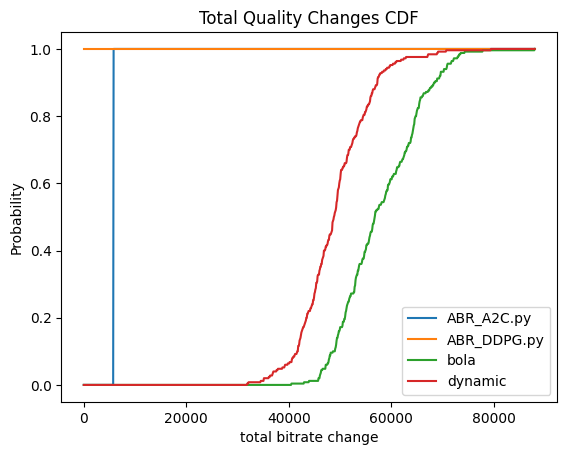

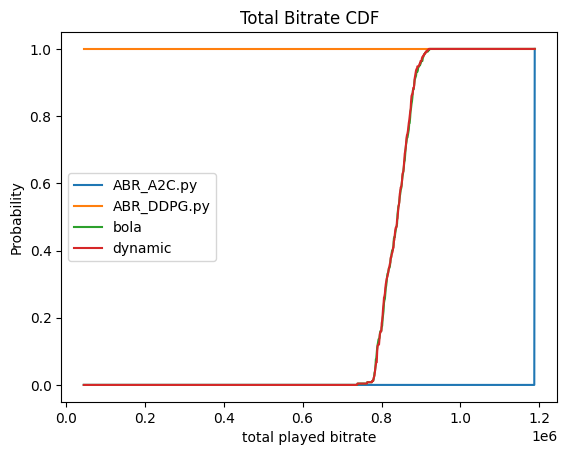

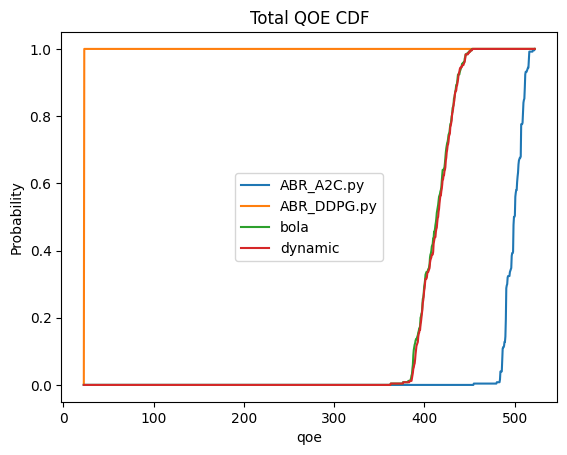

In [ ]:
%matplotlib inline
try:
    results_df
except NameError: 
    print('cell defining results df not run, so loading df from csv')
    results_df = pd.read_csv('../results/results_df.csv')

def plot_cdf(metric, title):
    data = []
    fig, ax = plt.subplots()
    ax.set_title(title)
    labels = list(results_df['algorithm'].unique())
    min_val = min(results_df[metric])
    max_val = max(results_df[metric])
    x_vals = np.linspace(stop=max_val, start=min_val, num=1000)
    for algo in labels:
        data = results_df[results_df['algorithm'] == algo][metric]
        y_vals = [data.loc[lambda f: f <= x].shape[0]/data.shape[0] for x in x_vals]
        ax.plot(x_vals, y_vals, label=algo)
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel(metric)
    plt.show()

plot_cdf(metric='total rebuffer', 
         title='Total Rebuffer Time CDF')

plot_cdf(metric='total bitrate change', 
         title='Total Quality Changes CDF')

plot_cdf(metric='total played bitrate', 
         title='Total Bitrate CDF')

plot_cdf(metric='qoe', 
         title='Total QOE CDF')


In [ ]:
results_df.head()